# ***Diabetic Retinopathy Prediction using CNN and Transfer Learning***
#### Sahil Mhatre
**Problem:**
Diabetic retinopathy (DR) is one of the most common and serious complications of diabetes, affecting the eyes by causing damage to the blood vessels of the retina. This condition is the leading cause of blindness in working-age adults worldwide. Diabetic retinopathy progresses in stages, starting with mild signs before advancing to more severe stages, where there is significant damage to the retina, resulting in vision loss or blindness. Early detection of diabetic retinopathy is critical, as timely treatment can prevent up to 90% of blindness cases. However, diagnosing DR requires specialized knowledge, and traditional methods involve manual inspection of retinal fundus images by trained ophthalmologists.


---


**Objective:**  
* Automation of Diabetic Retinopathy Diagnosis
* Early detection of diabetic retinopathy progression
* Leveraging Transfer Learning for Efficient Model Training

To develop an efficient machine learning model to accurately classify retinal fundus images into one of five diabetic retinopathy (DR) severity levels. By leveraging deep learning and transfer learning techniques, the model aims to automate the detection and classification of DR, providing a valuable tool for healthcare professionals in clinical settings.



## **Dataset**

https://www.kaggle.com/competitions/aptos2019-blindness-detection

The Asia Pacific Tele-Ophthalmology Society 2019 Blindness Detection (APTOS 2019 BD) dataset contains 3662 samples collected from many participants of rural India. The, Aravind Eye Hospital, India, organized the dataset. The fundus photographs were collected in varying conditions and environments over a long period. Later, a group of trained doctors reviewed and labeled the gathered samples following the principle of the International Clinical Diabetic Retinopathy Disease Severity Scale (ICDRSS).

As per the scaling system, the APTOS 2019 BD samples are divided into five categories:
* no Diabetic Retinopathy (DR)
* mild DR
* moderate DR
* severe DR
* proliferative DR.

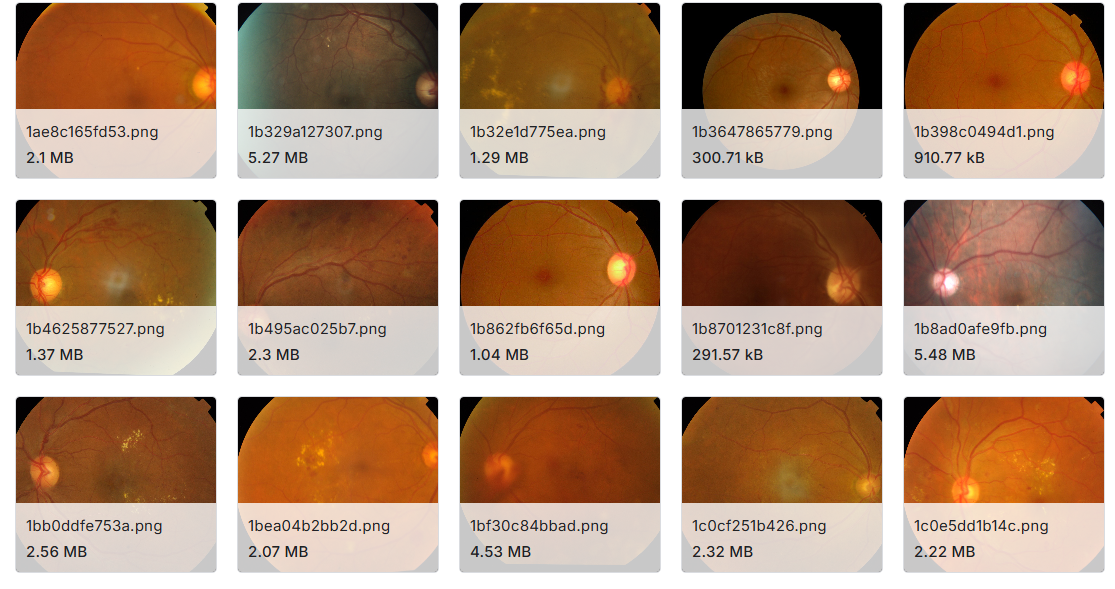

# **Setup**

### Imports

* **Numpy** for numerical computations.
* **Pandas** for data manipulation and handling.
* **TensorFlow** and **Keras** for building and training the deep learning model.
* **Matplotlib** for data visualization.
* **Sklearn** for metrics to evaluate the classification model.

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MachineLearning/Assessment2

# %ls /content/drive/MyDrive/MachineLearning/Assessment2/train_images
#!unzip /content/drive/MyDrive/MachineLearning/Assessment2/train_images.zip -d /content/drive/MyDrive/MachineLearning/Assessment2/train_images

### Extra FileName Formatting

In [ ]:
image_path = '/content/drive/MyDrive/MachineLearning/Assessment2/resized_train_images'

for filename in os.listdir(image_path):
  if not filename.endswith('.png'):
    new_filename = filename + '.png'

    old_file = os.path.join(image_path, filename)
    new_file = os.path.join(image_path, new_filename)

    os.rename(old_file, new_file)

  # if filename.endswith('.jpg'):
  #   new_filename = filename[:-4]

  #   old_file = os.path.join(image_path, filename)
  #   new_file = os.path.join(image_path, new_filename)

  #   os.rename(old_file, new_file)

### Process train.csv

Had to append ".png" to id_code to match image filenames.
Numeric ratings are converted to strings.

In [ ]:
labels = pd.read_csv('/content/drive/MyDrive/MachineLearning/Assessment2/train.csv')

#labels['diagnosis'] = labels['diagnosis'].apply(lambda x: 1 if x>0 else 0)
labels['diagnosis'] = labels['diagnosis'].astype(str)
labels['id_code'] = labels['id_code'].str.strip()
labels['id_code'] = labels['id_code'].apply(lambda x: str(x) + '.png')
labels.head()

### Image resizing

In [ ]:
# from PIL import Image
# import os

# def resize_with_aspect_ratio(img, target_size=(299, 299), background_color=(0, 0, 0)):
#     """Resize image to the target size while maintaining the aspect ratio, padding if necessary."""
#     img.thumbnail(target_size, Image.Resampling.LANCZOS)  # Resize while maintaining aspect ratio
#     new_img = Image.new("RGB", target_size, background_color)  # Create a new image with padding
#     new_img.paste(
#         img, ((target_size[0] - img.size[0]) // 2, (target_size[1] - img.size[1]) // 2)
#     )  # Paste resized image into the center of the new image
#     return new_img

# # Path to your images and where to save resized images
# image_path = '/content/drive/MyDrive/MachineLearning/Assessment2/train_images'
# output_path = '/content/drive/MyDrive/MachineLearning/Assessment2/resized_train_images'

# # Create a directory to save resized images if it doesn't exist
# if not os.path.exists(output_path):
#     os.makedirs(output_path)

# # Resize images and save them to the new directory
# for filename in os.listdir(image_path):
#     if filename.endswith('.png'):
#         img = Image.open(os.path.join(image_path, filename))
#         resized_img = resize_with_aspect_ratio(img, target_size=(299, 299))
#         resized_img.save(os.path.join(output_path, filename))
#         print(f"Resized and saved {filename}")

import os

output_p='/content/drive/MyDrive/MachineLearning/Assessment2/resized_train_images'
num_files = len([f for f in os.listdir(output_p) if f.endswith('.png')])
print(num_files)


### Process train_image

* ImageDataGenerator normalizes pixel values (0-255 to 0-1) and splits the dataset into 80% training and 20% validation.
*  Loads images and their labels, resizes them to 299x299 (required by InceptionV3), and processes them in batches of 32. Only 80% of the data is used for training.
* Remaining 20% is for validation

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/drive/MyDrive/MachineLearning/Assessment2/resized_train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size = (299,299),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    verbose = 2
)

val_data = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content/drive/MyDrive/MachineLearning/Assessment2/resized_train_images',
    x_col='id_code',
    y_col='diagnosis',
    target_size = (299,299),
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',
    verbose = 2
)

# **Building The CNN Model**

### Pre-trained InceptionV3 + Custom Layers


*   Loads the InceptionV3 model pre-trained on ImageNet without the top layers. The base model's layers are frozen to retain pre-learned features.
*   **Custom Layers**: A Flatten layer converts the 2D features into 1D. A Dense layer with 128 neurons and ReLU activation is added, followed by Dropout to prevent overfitting. The output layer has 5 units (one for each class) with softmax activation for multi-class classification.
* **Compiling**: The model uses the Adam optimizer and categorical cross-entropy for multi-class classification. The model is then compiled and summarized to check the structure


---

Loss function used: Categorical_CrossEntropy
* Used for multi-categorical classification
* The goal is to minimize this difference (or "loss") during training, so the model's predictions get closer to the true class labels.


In [ ]:
# Load the pre-trained InceptionV3 model without the top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers initially
base_model.trainable = False

# Create a Sequential model and add the base InceptionV3 model with custom layers
model = Sequential([
    base_model,
    Flatten(),  # Try Flatten() here if issues persist
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 output units for 5 classes
])

model.build(input_shape=(None, 299, 299, 3))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


### Callbacks

**EarlyStopping**: Monitors the validation loss during training.
Training stops if the validation loss does not improve for 3 consecutive epochs to prevent overfitting.

---


**TensorBoard**: Logs training metrics (like loss and accuracy) for visualization in TensorBoard. It helps track training progress and compare different runs.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='logs')

### Training

**Model Training**: The model is trained on the training data for 10 epochs.

**Validation Data**: The model's performance is evaluated on the validation data after each epoch.

**Callbacks**: Includes **EarlyStopping** to halt training if validation loss doesn't improve, and **TensorBoard** to log metrics for visualization.

In [ ]:
history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    callbacks=[early_stop, tensorboard]
)

In [ ]:
model.save('db_v1.keras')

# **Evaluations**

## Validation Data

In [ ]:
# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_data)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')

**Accuracy** from model.evaluate(val_data) (73%):

* Measures the overall proportion of correct predictions out of the total validation examples.
* Does not account for class imbalance. The model may perform well on majority classes, boosting the overall accuracy.
* Accuracy = (Number of Correct Predictions) / (Total Number of Predictions)


---


**Validation Loss**: 0.8190:
This is the final validation loss value reported after evaluation, very close to the batch loss, indicating consistency.

## Plotting Training and Validation Accuracy

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**Train Accuracy**: Shows model's accuracy on training data across epochs.

*   Steady increase starting from %60 and plateaus around 70%
*   Gradual rise shows model is effectively learning without overfitting

Validation Accuracy: Model's accuracy on validation data.
* Starts much higher around 70% and plateaus around 73%
* Model is generalizing well to unseen data


---

**Validation Accuracy Stays Higher**: The validation accuracy consistently outperforms the training accuracy. This is common in transfer learning since the pre-trained model already has useful learned features from the ImageNet dataset.

**Plateauing of Both Curves**: Both curves plateau after a few epochs, indicating that further training may not significantly improve performance. The model may have reached its optimal accuracy around 73%.


## Plotting Training and Validation Loss

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

**Train Loss** - starts high around 4.5 and rapidly drops. Shows that model is quickly learning and reduces error dramatically after initial training phase

**Validation Loss** - Starts much lower around 1.0 and decreases over epochs stabilizing near 0.8


---

**Rapid Drop in Training Loss**: The steep decrease in training loss during the first few epochs indicates that the model is learning quickly and effectively. This is a positive sign that the model is fitting the training data well.

**No Overfitting**: The validation loss stays close to the training loss throughout the epochs. If the validation loss were to increase while training loss continued to decrease, it would indicate overfitting. However, in this case, both losses stay close, showing that the model generalizes well to the validation data.

## Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Predict on validation data
val_pred = model.predict(val_data)
val_pred_classes = np.argmax(val_pred, axis=1)  # Convert probabilities to class labels

# True labels
true_classes = val_data.classes

# Generate a classification report
print(classification_report(true_classes, val_pred_classes, target_names=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']))


**Accuracy from classification_report()**(38%):

* Reflects a detailed breakdown of performance using precision, recall, and F1-score for each class.
* Includes metrics for minority classes (e.g., "Mild," "Severe," and "Proliferative"), which have very low performance (0 precision/recall/F1-score), bringing down the overall score.


---



* The dataset is imbalanced, with many more examples of "No DR" and "Moderate" compared to the minority classes.
* The model performs better on majority classes, which boosts overall accuracy but struggles with minority classes, lowering the performance seen in the classification report.


## Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get true labels and predicted labels
y_true = val_data.classes
y_pred = np.argmax(model.predict(val_data), axis=-1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'],
            yticklabels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


* The model performs best for No DR and Moderate classes but struggles to distinguish between the more subtle severity levels of diabetic retinopathy.
* The confusion between No DR and Moderate DR highlights the need to improve the model's sensitivity, particularly for early-stage diagnosis (Mild/Severe/Proliferative).
* Improvements could include balancing the dataset, applying class weighting, or fine-tuning the model further to better handle underrepresented classes.

## ROC Curves for Multi-Class Classification

Plotting the ROC Curves: The ROC curve for each class is plotted, along with the AUC score. A diagonal line (k--) represents random guessing, and better models will have curves above this line.

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
y_pred_prob = model.predict(val_data)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):  # 5 classes for diabetic retinopathy
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Diabetic Retinopathy Classification')
plt.legend(loc='lower right')
plt.show()


Best Performance: The model performs slightly better for Class 4 (Proliferative DR) with an AUC of 0.54, which is still very close to random guessing.

Lowest Performance: The Moderate DR (Class 2) class has the lowest AUC at 0.45, indicating poor discrimination between positive and negative cases for this class.

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!ls

 Applied_RAG_Pipeline_with_LLaMA_and_ChromaDB.ipynb
'Transfer Learning InceptionV3:Diabetic Retinopathy.ipynb'


In [32]:
import nbformat
from nbformat.validator import validate

# Path to your notebook
path = "/content/drive/MyDrive/Colab Notebooks/Applied_RAG_Pipeline_with_LLaMA_and_ChromaDB.ipynb"

# Load notebook
nb = nbformat.read(path, as_version=4)

# --- Clean metadata ---
# Remove top-level widget metadata if present
if "widgets" in nb.get("metadata", {}):
    del nb["metadata"]["widgets"]

# Clean outputs
for cell in nb.cells:
    if "outputs" in cell:
        for out in cell["outputs"]:
            # Remove illegal metadata keys
            if "metadata" in out and out["output_type"] == "stream":
                del out["metadata"]

# (Optional) Clear all outputs to keep repo lightweight
clear_outputs = True
if clear_outputs:
    for cell in nb.cells:
        if "outputs" in cell:
            cell["outputs"] = []
        if "execution_count" in cell:
            cell["execution_count"] = None

# Validate notebook structure
validate(nb)

# Save cleaned notebook
nbformat.write(nb, path)
print(f"✅ Cleaned notebook saved at: {path}")


✅ Cleaned notebook saved at: /content/drive/MyDrive/Colab Notebooks/Applied_RAG_Pipeline_with_LLaMA_and_ChromaDB.ipynb
